# 영화리뷰 감성분석기

이번시간에는 자연어 처리에 주로 활용되는 RNN을 활용하여 영화 리뷰 감성분석기 자연어 처리 모델을 구현해 본다. 
학습 목표는 아래와 같다. 

- 텍스트 데이터를 머신러닝 입출력용 수치데이터로 변환하는 과정을 이해한다.
- RNN의 특징을 이해하고 시퀀셜한 데이터를 다루는 방법을 이해한다.
- 1-D CNN으로도 텍스트를 처리할 수 있음을 이해한다.
- IMDB와 네이버 영화리뷰 데이터셋을 이용한 영화리뷰 감성 분류 실습을 진행한다.

구현을 진행할 순서는 아래와 같다. 

    1. 데이터 준비와 확인
    2. 데이터로더 구성
    3. 모델 구성을 위한 데이터 분석 및 가공
    4. 모델 구성 및 validation set 구성
    5. 모델 훈련 개시
    6. 모델 평가
    7. 학습된 Embedding Layer 분석
    8. 한국어 Word2Vec 임베딩 활용하여 성능 개선 
    9. 결론 및 후기

시작해보자

## 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
import tensorflow 
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter


# 데이터 파일 읽기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터로더 구성

데이터로더에서 다음의 사항을 수행해야 한다. 

    - 데이터의 중복 제거
    - NaN 결측치 제거
    - 한국어 토크나이저로 토큰화
    - 불용어(Stopwords) 제거
    - 사전 word_to_index 구성
    - 텍스트 스트링을 사전 인덱스 스트링으로 변환
    - X_train, y_train, X_test, y_test, word_to_index 리턴
    
위의 기능을 포함한 데이터로더 함수를 구현한다. 


### 데이터로더 함수 구현

In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '']+[key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print(f'train data 개수: {len(X_train)}, test data 개수: {len(X_test)}')

train data 개수: 146182, test data 개수: 49157


### {숫자:단어} 형태의 딕셔너리 생성

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

### 필요한 함수 기능 작성

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### encode된 텍스트 데이터가 decode 되는지 확인

In [5]:
print(X_train[0])
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


## 3. 모델 구성을 위한 데이터 분석 및 가공

### 데이터의 문장 길이 정제
문장이 너무 길면 학습과 모델 성능에 좋지 않은 영향을 미치게 되므로 적절한 값으로 정제해야한다. 이를 위해 데이터셋의 문장길이의 분포를 확인하고 적절한 길이로 설정한다. 

In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### 문장 길이를 통일시켜주기 위해 padding 적용
padding을 적용할 방식을 문장 뒤쪽(post)와 앞쪽(pre) 중 어느쪽으로 할지에 따라 성능차이가 발생하기 때문에 확인을 위해 각각 따로 적용하여 진행한다. 

In [7]:
X_train_pre = tensorflow.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=maxlen)

X_test_pre = tensorflow.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=maxlen)

print(X_train_pre.shape)

(146182, 41)


In [8]:
X_train_post = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=maxlen)

X_test_post = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', 
                                                       maxlen=maxlen)

print(X_train_post.shape)

(146182, 41)


### 각각 적용된 패딩 확인

In [9]:
print(X_train_pre[0])
print(get_decoded_sentence(X_train_pre[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

[ 32  74 919   4   4  39 228  20  33 748   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]
더 빙 . . 진짜 짜증 나 네요 목소리 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
라벨:  0


In [10]:
print(X_train_post[0])
print(get_decoded_sentence(X_train_post[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

[ 32  74 919   4   4  39 228  20  33 748   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]
더 빙 . . 진짜 짜증 나 네요 목소리 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
라벨:  0


## 4. 모델 구성 및 validation set 구성

### validation set 구성 

In [11]:
# validation set 10000건 분리
X_val_pre = X_train_pre[:45000]    # pre 패딩된 train set 분리
X_val_post = X_train_post[:45000]  # post 패딩된 train set 분리
y_val = y_train[:45000]

# validation set을 제외한 나머지
partial_X_train_pre = X_train_pre[45000:]
partial_X_train_post = X_train_post[45000:]
partial_y_train = y_train[45000:]

# validation set 갯수
print(X_val_pre.shape)
print(X_val_post.shape)
print(y_val.shape)

# train set 갯수
print(partial_X_train_pre.shape)
print(partial_X_train_post.shape)
print(partial_y_train.shape)

(45000, 41)
(45000, 41)
(45000,)
(101182, 41)
(101182, 41)
(101182,)


### 모델 구성
3가지의 다양한 모델로 데이터셋을 학습시킨다. 여기서는 아래의 모델을 구성하고 학습시킨다. 

    1) RNN 모델
    2) CNN 모델
    3) GlobalMaxPooling1D() 모델
    
각각의 모델을 pre, post 패딩 데이터로 따로 학습시킨다. 

### 1) RNN 모델

In [12]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# LSTM 레이어로 모델 설계
model_rnn_pre = keras.Sequential()
model_rnn_pre.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn_pre.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원수 (변경가능)
model_rnn_pre.add(keras.layers.Dense(8, activation='relu'))
model_rnn_pre.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_rnn_pre.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [13]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# LSTM 레이어로 모델 설계
model_rnn_post = keras.Sequential()
model_rnn_post.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn_post.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원수 (변경가능)
model_rnn_post.add(keras.layers.Dense(8, activation='relu'))
model_rnn_post.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_rnn_post.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### 2) CNN 모델

In [14]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 1-D CNN 모델 설계
model_1dcnn_pre = keras.Sequential()
model_1dcnn_pre.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1dcnn_pre.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_1dcnn_pre.add(keras.layers.MaxPooling1D(5))
model_1dcnn_pre.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_1dcnn_pre.add(keras.layers.GlobalMaxPooling1D())
model_1dcnn_pre.add(keras.layers.Dense(8, activation='relu'))
model_1dcnn_pre.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_1dcnn_pre.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [15]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 1-D CNN 모델 설계
model_1dcnn_post = keras.Sequential()
model_1dcnn_post.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1dcnn_post.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_1dcnn_post.add(keras.layers.MaxPooling1D(5))
model_1dcnn_post.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_1dcnn_post.add(keras.layers.GlobalMaxPooling1D())
model_1dcnn_post.add(keras.layers.Dense(8, activation='relu'))
model_1dcnn_post.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_1dcnn_pre.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

### 3) GlobalMaxPooling1D() 모델

In [16]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원 수
# GlobalMaxPooling1D() 레이어 하나만 사용하여 모델 설계
model_gmp_pre = keras.Sequential()
model_gmp_pre.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp_pre.add(keras.layers.GlobalMaxPooling1D())
model_gmp_pre.add(keras.layers.Dense(8, activation='relu'))
model_gmp_pre.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_gmp_pre.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [17]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원 수
# GlobalMaxPooling1D() 레이어 하나만 사용하여 모델 설계
model_gmp_post = keras.Sequential()
model_gmp_post.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp_post.add(keras.layers.GlobalMaxPooling1D())
model_gmp_post.add(keras.layers.Dense(8, activation='relu'))
model_gmp_post.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_gmp_post.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


## 5. 모델 학습

### 5-1. RNN 모델로 pre 패딩 데이터셋 학습

In [18]:
model_rnn_pre.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_rnn_pre = model_rnn_pre.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/5
198/198 [==============================] - 5s 8ms/step - loss: 0.5750 - accuracy: 0.6793 - val_loss: 0.4206 - val_accuracy: 0.8196
Epoch 2/5
198/198 [==============================] - 1s 6ms/step - loss: 0.3605 - accuracy: 0.8484 - val_loss: 0.3519 - val_accuracy: 0.8479
Epoch 3/5
198/198 [==============================] - 1s 6ms/step - loss: 0.3225 - accuracy: 0.8660 - val_loss: 0.3497 - val_accuracy: 0.8478
Epoch 4/5
198/198 [==============================] - 1s 6ms/step - loss: 0.3065 - accuracy: 0.8726 - val_loss: 0.3535 - val_accuracy: 0.8478
Epoch 5/5
198/198 [==============================] - 1s 6ms/step - loss: 0.2963 - accuracy: 0.8759 - val_loss: 0.3576 - val_accuracy: 0.8466


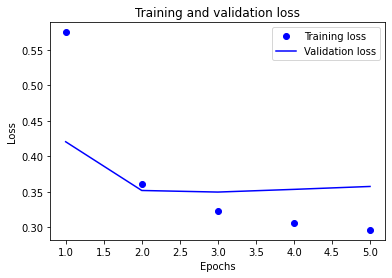

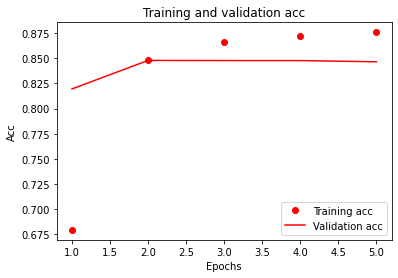

In [19]:
history_rnn_pre_dict = history_rnn_pre.history

acc = history_rnn_pre_dict['accuracy']
val_acc = history_rnn_pre_dict['val_accuracy']
loss = history_rnn_pre_dict['loss']
val_loss = history_rnn_pre_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# "ro"는 "빨간색 점"입니다
plt.plot(epochs, acc, 'ro', label='Training acc')
# r는 "빨간 실선"입니다
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

### Test 셋으로 평가

In [20]:
results = model_rnn_pre.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3674 - accuracy: 0.8416
[0.3674054741859436, 0.8415892124176025]


### 5-2. RNN 모델로 post 패딩 데이터셋 학습

In [21]:
model_rnn_post.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_rnn_post = model_rnn_post.fit(partial_X_train_post,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_post, y_val),
                    verbose=1)

Epoch 1/5
198/198 [==============================] - 3s 8ms/step - loss: 0.5499 - accuracy: 0.7321 - val_loss: 0.4047 - val_accuracy: 0.8360
Epoch 2/5
198/198 [==============================] - 1s 6ms/step - loss: 0.3608 - accuracy: 0.8521 - val_loss: 0.3618 - val_accuracy: 0.8405
Epoch 3/5
198/198 [==============================] - 1s 6ms/step - loss: 0.3237 - accuracy: 0.8674 - val_loss: 0.3805 - val_accuracy: 0.8335
Epoch 4/5
198/198 [==============================] - 1s 6ms/step - loss: 0.3116 - accuracy: 0.8719 - val_loss: 0.3504 - val_accuracy: 0.8474
Epoch 5/5
198/198 [==============================] - 1s 6ms/step - loss: 0.3032 - accuracy: 0.8753 - val_loss: 0.3586 - val_accuracy: 0.8451


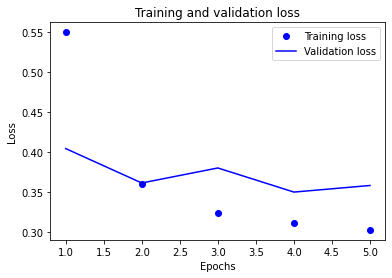

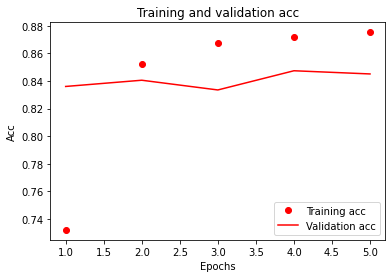

In [22]:
history_rnn_post_dict = history_rnn_post.history

acc = history_rnn_post_dict['accuracy']
val_acc = history_rnn_post_dict['val_accuracy']
loss = history_rnn_post_dict['loss']
val_loss = history_rnn_post_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# "ro"는 "빨간색 점"입니다
plt.plot(epochs, acc, 'ro', label='Training acc')
# r는 "빨간 실선"입니다
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

### Test 셋으로 평가

In [23]:
results = model_rnn_post.evaluate(X_test_post,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3699 - accuracy: 0.8405
[0.36992719769477844, 0.8405313491821289]


### 5-3. CNN 모델로 pre 패딩 데이터셋 학습

In [24]:
model_1dcnn_pre.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_1dcnn_pre = model_1dcnn_pre.fit(partial_X_train_pre,
                                       partial_y_train,
                                       epochs=epochs,
                                       batch_size=512,
                                       validation_data=(X_val_pre, y_val),
                                       verbose=1)

Epoch 1/5
198/198 [==============================] - 3s 6ms/step - loss: 0.5379 - accuracy: 0.7338 - val_loss: 0.3678 - val_accuracy: 0.8398
Epoch 2/5
198/198 [==============================] - 1s 5ms/step - loss: 0.3405 - accuracy: 0.8548 - val_loss: 0.3474 - val_accuracy: 0.8498
Epoch 3/5
198/198 [==============================] - 1s 5ms/step - loss: 0.3036 - accuracy: 0.8744 - val_loss: 0.3536 - val_accuracy: 0.8478
Epoch 4/5
198/198 [==============================] - 1s 5ms/step - loss: 0.2788 - accuracy: 0.8863 - val_loss: 0.3530 - val_accuracy: 0.8504
Epoch 5/5
198/198 [==============================] - 1s 5ms/step - loss: 0.2565 - accuracy: 0.8978 - val_loss: 0.3591 - val_accuracy: 0.8501


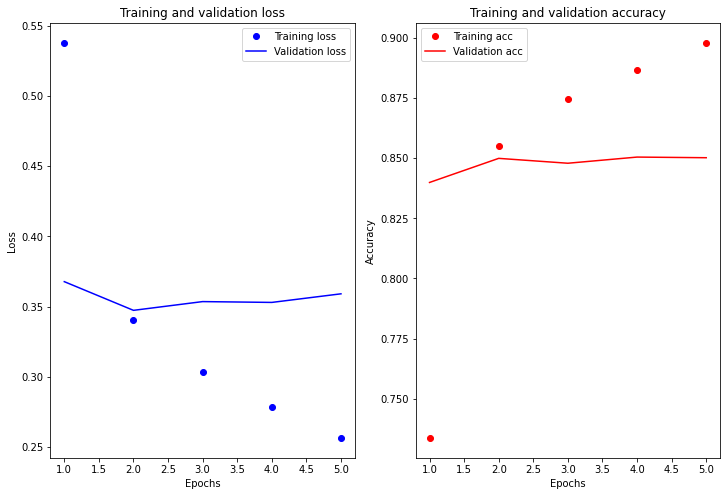

In [25]:
history_1dcnn_pre_dict = history_1dcnn_pre.history

acc = history_1dcnn_pre_dict['accuracy']
val_acc = history_1dcnn_pre_dict['val_accuracy']
loss = history_1dcnn_pre_dict['loss']
val_loss = history_1dcnn_pre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


### Test셋으로 평가

In [26]:
results = model_1dcnn_pre.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3683 - accuracy: 0.8458
[0.36828136444091797, 0.8458002209663391]


### 5-4. CNN 모델로 post 패딩 데이터셋 학습

In [27]:
model_1dcnn_post.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_1dcnn_post = model_1dcnn_post.fit(partial_X_train_post,
                                       partial_y_train,
                                       epochs=epochs,
                                       batch_size=512,
                                       validation_data=(X_val_post, y_val),
                                       verbose=1)

Epoch 1/5
198/198 [==============================] - 2s 6ms/step - loss: 0.5430 - accuracy: 0.7134 - val_loss: 0.3640 - val_accuracy: 0.8408
Epoch 2/5
198/198 [==============================] - 1s 5ms/step - loss: 0.3360 - accuracy: 0.8572 - val_loss: 0.3440 - val_accuracy: 0.8500
Epoch 3/5
198/198 [==============================] - 1s 6ms/step - loss: 0.2959 - accuracy: 0.8780 - val_loss: 0.3443 - val_accuracy: 0.8519
Epoch 4/5
198/198 [==============================] - 1s 5ms/step - loss: 0.2682 - accuracy: 0.8910 - val_loss: 0.3536 - val_accuracy: 0.8498
Epoch 5/5
198/198 [==============================] - 1s 5ms/step - loss: 0.2424 - accuracy: 0.9041 - val_loss: 0.3613 - val_accuracy: 0.8496


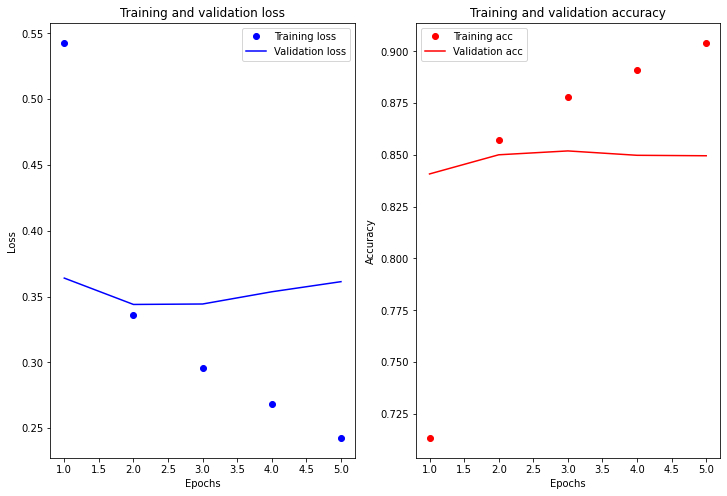

In [28]:
history_1dcnn_post_dict = history_1dcnn_post.history

acc = history_1dcnn_post_dict['accuracy']
val_acc = history_1dcnn_post_dict['val_accuracy']
loss = history_1dcnn_post_dict['loss']
val_loss = history_1dcnn_post_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Test셋으로 평가

In [29]:
results = model_1dcnn_post.evaluate(X_test_post,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3708 - accuracy: 0.8453
[0.3708256781101227, 0.8452509045600891]


### 5-5. GlobalMaxPooling1D() 모델로 pre 패딩 데이터셋 학습

In [30]:
model_gmp_pre.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_gmp_pre = model_gmp_pre.fit(partial_X_train_pre,
                                       partial_y_train,
                                       epochs=epochs,
                                       batch_size=512,
                                       validation_data=(X_val_pre, y_val),
                                       verbose=1)

Epoch 1/5
198/198 [==============================] - 1s 4ms/step - loss: 0.6150 - accuracy: 0.7342 - val_loss: 0.4803 - val_accuracy: 0.8130
Epoch 2/5
198/198 [==============================] - 1s 4ms/step - loss: 0.4037 - accuracy: 0.8314 - val_loss: 0.3709 - val_accuracy: 0.8373
Epoch 3/5
198/198 [==============================] - 1s 4ms/step - loss: 0.3386 - accuracy: 0.8564 - val_loss: 0.3558 - val_accuracy: 0.8440
Epoch 4/5
198/198 [==============================] - 1s 4ms/step - loss: 0.3067 - accuracy: 0.8729 - val_loss: 0.3532 - val_accuracy: 0.8461
Epoch 5/5
198/198 [==============================] - 1s 4ms/step - loss: 0.2829 - accuracy: 0.8837 - val_loss: 0.3567 - val_accuracy: 0.8465


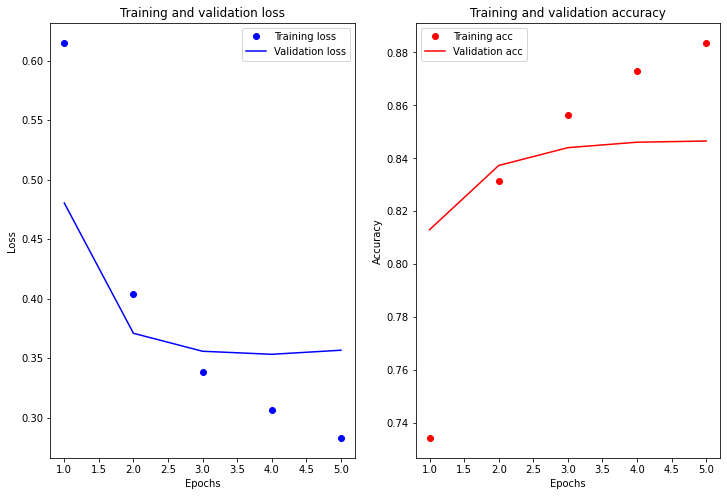

In [31]:
history_gmp_pre_dict = history_gmp_pre.history

acc = history_gmp_pre_dict['accuracy']
val_acc = history_gmp_pre_dict['val_accuracy']
loss = history_gmp_pre_dict['loss']
val_loss = history_gmp_pre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


### Test셋으로 평가

In [32]:
results = model_gmp_pre.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3650 - accuracy: 0.8418
[0.36501529812812805, 0.8417722582817078]


### 5-6. GlobalMaxPooling1D() 모델로 post 패딩 데이터셋 학습

In [33]:
model_gmp_post.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_gmp_post = model_gmp_post.fit(partial_X_train_post,
                                       partial_y_train,
                                       epochs=epochs,
                                       batch_size=512,
                                       validation_data=(X_val_post, y_val),
                                       verbose=1)

Epoch 1/5
198/198 [==============================] - 1s 4ms/step - loss: 0.6320 - accuracy: 0.6909 - val_loss: 0.5150 - val_accuracy: 0.8020
Epoch 2/5
198/198 [==============================] - 1s 4ms/step - loss: 0.4221 - accuracy: 0.8280 - val_loss: 0.3746 - val_accuracy: 0.8380
Epoch 3/5
198/198 [==============================] - 1s 4ms/step - loss: 0.3401 - accuracy: 0.8568 - val_loss: 0.3547 - val_accuracy: 0.8448
Epoch 4/5
198/198 [==============================] - 1s 4ms/step - loss: 0.3067 - accuracy: 0.8726 - val_loss: 0.3519 - val_accuracy: 0.8460
Epoch 5/5
198/198 [==============================] - 1s 4ms/step - loss: 0.2835 - accuracy: 0.8833 - val_loss: 0.3550 - val_accuracy: 0.8460


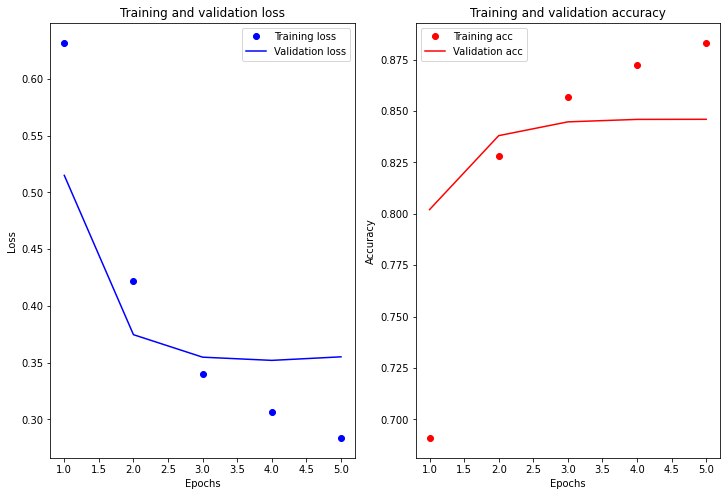

In [34]:
history_gmp_post_dict = history_gmp_post.history

acc = history_gmp_post_dict['accuracy']
val_acc = history_gmp_post_dict['val_accuracy']
loss = history_gmp_post_dict['loss']
val_loss = history_gmp_post_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Test셋으로 평가

In [35]:
results = model_gmp_post.evaluate(X_test_post,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3656 - accuracy: 0.8423
[0.36564183235168457, 0.8422605395317078]


## 6. 모델 평가
    1. RNN(pre ) : 84.16 %
          (post) : 84.05 %
          
    2. CNN(pre ) : 84.58 %
          (post) : 84.53 %
          
    3. GMP1D(pre ) : 84.18 %
            (post) : 84.23 %

## 7. 학습된 Embedding layer 분석

### 모델의 첫번째 레이어를 embedding layer로 할당

In [36]:
embedding_layer = model_rnn_pre.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


### Embedding layer에 학습된 워드 벡터 기록

In [37]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_project.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록
vectors = model_rnn_pre.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

### gensim 패키지를 이용해 Embedding parameter를 word vector로 활용

In [38]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("하늘")

[('익숙', 0.7416452765464783),
 ('투', 0.7323955297470093),
 ('바뀔', 0.6923524141311646),
 ('정말로', 0.6643781661987305),
 ('만지', 0.654167115688324),
 ('드러난다', 0.6488943696022034),
 ('지하', 0.6385790109634399),
 ('만만', 0.6184035539627075),
 ('유오성', 0.5989598631858826),
 ('계약', 0.5982666015625)]

In [39]:
word_vectors.similar_by_word("바다")

[('""', 0.7632853984832764),
 ('저렇', 0.7425193190574646),
 ('깨달', 0.7348558306694031),
 ('보영', 0.7118668556213379),
 ('배틀', 0.7098310589790344),
 ('단면', 0.6913696527481079),
 ('공식', 0.6900316476821899),
 ('대략', 0.6780614256858826),
 ('탈', 0.6748383641242981),
 ('세요', 0.6723508834838867)]

단어 하나를 제시하고 word vector로 전환했을때 원래 제시되었던 단어와 유사도가 떨어지는 단어가 제시되었다. 

## 8. 한국어 Word2Vec 임베딩 활용하여 성능개선

pip install --upgrade gensim==3.8.3 설치

In [40]:
import gensim
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['하늘']
vector.shape     # 200dim의 워드 벡터

/tmp/ipykernel_1685/434912183.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['하늘']


(200,)

In [41]:
word2vec.similar_by_word("하늘")

/tmp/ipykernel_1685/1004379924.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("하늘")


[('보름달', 0.5647983551025391),
 ('지옥', 0.5606871843338013),
 ('바다', 0.5598345398902893),
 ('태양', 0.5543240904808044),
 ('저승', 0.5534777641296387),
 ('세상', 0.5530140399932861),
 ('영혼', 0.5516394376754761),
 ('햇살', 0.5444256067276001),
 ('하느님', 0.5399892926216125),
 ('빛', 0.5351409912109375)]

In [42]:
word2vec.similar_by_word("바다")

/tmp/ipykernel_1685/2185404609.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("바다")


[('육지', 0.7259926795959473),
 ('호수', 0.6840913891792297),
 ('바닷속', 0.6585341691970825),
 ('바닷가', 0.6451719403266907),
 ('늪', 0.6421072483062744),
 ('급류', 0.6311373710632324),
 ('바닷물', 0.6305385231971741),
 ('절벽', 0.6251566410064697),
 ('바위', 0.6213432550430298),
 ('골짜기', 0.6192145347595215)]

In [43]:
word2vec.similar_by_word("산")

/tmp/ipykernel_1685/2617520188.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("산")


[('산의', 0.7235683798789978),
 ('산과', 0.6179043054580688),
 ('기슭', 0.5736351013183594),
 ('산기슭', 0.566975474357605),
 ('동편', 0.5566598176956177),
 ('산계', 0.5555674433708191),
 ('계곡', 0.5549115538597107),
 ('산맥', 0.5487329363822937),
 ('언덕', 0.5379024147987366),
 ('산중', 0.5327262878417969)]

In [44]:
word2vec.similar_by_word("우주")

/tmp/ipykernel_1685/2108708290.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("우주")


[('우주인', 0.5970312356948853),
 ('우주선', 0.5897793173789978),
 ('태양계', 0.5495188236236572),
 ('인공위성', 0.5380538105964661),
 ('발사체', 0.5338727235794067),
 ('생명체', 0.508995532989502),
 ('탐사선', 0.5014845728874207),
 ('외계', 0.49762025475502014),
 ('소유스', 0.49637308716773987),
 ('정거장', 0.4955979883670807)]

In [45]:
word2vec.similar_by_word("절벽")

/tmp/ipykernel_1685/470712310.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("절벽")


[('언덕', 0.7816677093505859),
 ('벼랑', 0.7741155624389648),
 ('골짜기', 0.7585533857345581),
 ('바위', 0.7493926286697388),
 ('암벽', 0.742572009563446),
 ('기암', 0.7364760637283325),
 ('산기슭', 0.7203370928764343),
 ('경사면', 0.710213840007782),
 ('괴석', 0.7096382975578308),
 ('연못', 0.6967140436172485)]

In [46]:
word2vec.similar_by_word("태양계")

/tmp/ipykernel_1685/878481097.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("태양계")


[('은하계', 0.783160924911499),
 ('해왕성', 0.7697625160217285),
 ('항성', 0.7588958740234375),
 ('행성', 0.740221381187439),
 ('명왕성', 0.7398768663406372),
 ('천체', 0.734818696975708),
 ('천왕성', 0.7224814891815186),
 ('은하', 0.7186455726623535),
 ('목성', 0.7118706703186035),
 ('성운', 0.7083038687705994)]

Word2Vec에서 제공하는 워드 임베딩 벡터들끼리는 유사도가 가까운것이 서로 가깝게 학습된 것을 확인할 수 있다. 
이전에 학습했던 모델의 첫번째 레이어(Embedding layer)를 Word2Vec으로 교체하여 RNN(pre) 모델을 학습시켜본다. 

### RNN 모델 작성 및 학습

In [47]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_1685/3778977091.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_1685/3778977091.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [48]:
# LSTM 레이어로 모델 설계
model_ko = keras.Sequential()
model_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_ko.add(keras.layers.LSTM(128))  # LSTM state 벡터의 차원수 (변경가능)
model_ko.add(keras.layers.Dense(8, activation='relu'))
model_ko.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_ko.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


In [49]:
model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5   

history_ko = model_ko.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/5
1581/1581 [==============================] - 12s 7ms/step - loss: 0.5154 - accuracy: 0.7006 - val_loss: 0.3493 - val_accuracy: 0.8438
Epoch 2/5
1581/1581 [==============================] - 10s 7ms/step - loss: 0.3144 - accuracy: 0.8644 - val_loss: 0.3192 - val_accuracy: 0.8619
Epoch 3/5
1581/1581 [==============================] - 10s 7ms/step - loss: 0.2638 - accuracy: 0.8895 - val_loss: 0.3152 - val_accuracy: 0.8656
Epoch 4/5
1581/1581 [==============================] - 10s 7ms/step - loss: 0.2241 - accuracy: 0.9078 - val_loss: 0.3266 - val_accuracy: 0.8636
Epoch 5/5
1581/1581 [==============================] - 10s 6ms/step - loss: 0.1866 - accuracy: 0.9251 - val_loss: 0.3486 - val_accuracy: 0.8616


### Acc, Loss 시각화

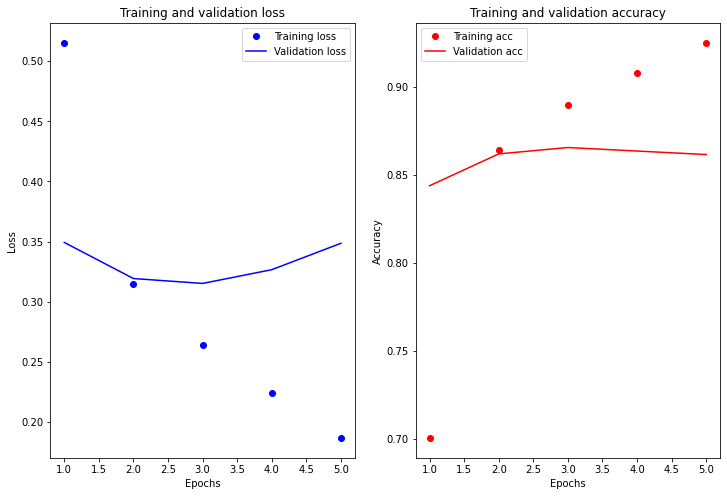

In [50]:
history_ko_dict = history_ko.history

acc = history_ko_dict['accuracy']
val_acc = history_ko_dict['val_accuracy']
loss = history_ko_dict['loss']
val_loss = history_ko_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Test셋으로 모델 성능 평가

In [51]:
results = model_ko.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3573 - accuracy: 0.8602
[0.35729360580444336, 0.8602233529090881]


## 9. 결론 및 후기

한국어 Word2Vec을 RNN의 첫번째 레이어에 적용해서 얻은 최종 Acc 수치는 86.02%를 기록하였다. 그래프상으로도 확인이 가능하지만 5번의 epochs는 오히려 역효과를 낳고 2번의 epchos가 현재까진 최적의 수치로 보인다. 그리고 padding 처리한 data셋을 pre와 post로 나누어 시험했었는데 대부분의 모델이 84%를 기록한걸 보면 노드에서 설명되었던 것과는 다르게 유의미한 차이를 보이진 않았다. 이번엔 하면서 이해가 가지 않는 부분이 많았는데 특히 Ebedding layer의 개념과 원리를 정확히 알지 못해 노드를 따라가기 벅찼다. 그래서 Word2Vec의 array가 어떤 방식으로 구성되어있는지도 이해하지 못했던 점이 아쉬웠다.